### Building a Bridge: From Fires to People

The goals of this notebook are to:

1. determine the cumulative fraction of each basin that has burned
2. determine the fraction of each basin's upstream watershed that has burned
3. map those values to flood hazard zones
4. map enhanced flood hazards to census tracts
5. integrate enhanced flood hazard and social vulnerability to prioritize census tracts

#### Step 0: Step Up

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Address a Conda <--> PROJ error

In [2]:
# Source: https://gis.stackexchange.com/questions/364421/how-to-make-proj-work-via-anaconda-in-google-colab
import os; os.environ['PROJ_LIB'] = '/path/to/env/share/proj'

Import fire data, changing to a common coordiante system that supports measurement. Full credit to Matt for finding the fire data and converting it to `.geojson`!

In [3]:
f=gpd.read_file("data/LAC_fires.geojson").to_crs(epsg=6933)

Next, import hydrologica basin data. This global data set is too big to import and needs a bounding box:

In [4]:
bbox = (-118.9441,32.8065,-117.6447,34.8227)
# Source: https://observablehq.com/@rdmurphy/u-s-county-bounding-boxes-by-state

Now it can be imported; select level 12 to get maximum spatial resolution

In [5]:
b=gpd.read_file("data/BasinATLAS_Data_v10.gdb.zip", driver='FileGDB', layer='BasinATLAS_v10_lev12',bbox=bbox)

As with fire data, change the coordinates to a common set that supports measurement

In [6]:
b=b.to_crs(6933)

From earlier basin exploration, we know we want to remove the two basins corresponding to islands:

In [7]:
b = b[b['HYBAS_ID']!=7120055730]
b = b[b['HYBAS_ID']!=7120055740]

#### Step 1: Determine the cumulative fraction of each basin that has been burned

What we want to do now is use the `intersection` function in geopandas to find the area of each fire-to-basin overlap and sum those areas for each basin. For example, if a basin was 20% burned by one fire and 15% burned by another, we want the outcome to be 35% -- regardless of whether or not the two fires themselves overlap (because, probably, they happened far enough apart to have "independent" impacts on runoff. A more advanced version would add a recovery function.

To do this, we transform both geodataframes into lists with one basin (or fire) per list entry and then use "list comprehension" syntax to map the pairs through the intersection calculation.

Use a ***loop*** to create a list "basins" with one entry per basin:

In [8]:
basins = []
for i in list(range(0,b.shape[0])):
    basins.append([b.iloc[i]])

Create a list "fires" with one entry per fire

In [9]:
fires = []
for i in list(range(0,f.shape[0])):
    fires.append([f.iloc[i]])

The next block is the heart of this section of code. These are three nested functions, that iterate through two lists of geographies, calculating the area of their intersection and summing them for each unit of one of the lists. Really this is two ***loops***, just written with more concise syntax.

In [10]:
def f1(a,b):
    return a[0]["geometry"].intersection(b[0]["geometry"]).area
def f2(b,aa):
    return sum([f1(a,b) for a in aa])
def f3(aa,bb):
    return [f2(b,aa) for b in bb]

Now we can use this set of functions to compute the area of fire intersection in each basin:

In [11]:
burned=f3(fires,basins)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Now `burned` is a list with one entry per basin, with the entry being the cumulative burned area. Let's make sure there are the right number of entries (the following three numbers should be the same):

In [12]:
print(len(burned))
print(len(basins))
print(b.shape[0])

133
133
133


Next, we want to assign each cumulative burned area to each basin, by creating a column in the geodataframe 'b' with values equal to the list 'burned'


In [13]:
b["burnt"] = burned

We show that this worked by plotting with color for cumulative burned fraction; save figure for presentation.

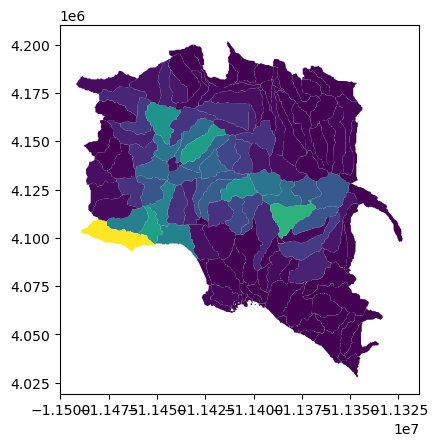

In [14]:
b.plot(column=b["burnt"])
plt.savefig("burnt.png")

Also, noting that this looks correct -- the fires are in the hills!

#### Step 2: Calculate for each basin the total burnt area in the basin and *upstream* of the basin.

The basin data already have a column providing the immediate *downstream* basin for each basin. For each basin, we need to identiy the immediate *upstream* basin(s).

First, we make a list where the nth entry is the *downstream* basin for for basin n. To do this, we create a function to look up the downstream basin (working in the basins list, not the geodataframe).

In [15]:
def get_down(basin):
    return basin[0][1]

Next, we apply that function to all basins in the basins list, returning a list of downstream basins. For anyone looking for loops, note that this is another ***loop***.

In [16]:
downs = [get_down(basin) for basin in basins]

Now we need a function to look up the basin id (again working in the basins list):

In [17]:
def get_id(basin):
    return basin[0][0]

And we apply that function to all basins in the list; returning an ordered list of basin ids for using in a lookup. And again, this is a ***loop***.

In [18]:
ids = [get_id(basin) for basin in basins]

Now, that we have these functions, we can describe the goal: constructing a square array where cell `[a,b]` is 1 if basin `b` drains into basin `a`, and otherwise is zero.

##### Step 2.1: make a square array with dimension matching the number of basins.
Using the `identity` function in numpy, we can make this an identity matrix, which is a) square, b) has value zero everywhere except 1 on the diagonal. This is helpful because each basin flows into itself for the purpose of our analysis.

In [19]:
up = np.identity(len(basins))

##### Step 2.2: use the `downs` list to set to 1 any `[a,b]` where basin `b` flows into basin `a`.

In [20]:
for d in range(0,len(downs)):
    if downs[d]!=0:
        try:
            up[ids.index(downs[d])][d]=1
        except:
            1+1

Now we have a square matrix showing all immediate upstream connections

##### Step 2.3: Iterate through the matrix of immediate upstream connections to find basins upstream of upstream basins, basins upstream of basins upstream of upstream basins, etc

This will consist of a function that pulls the indices of basins already known to be upstream and then many nested ***loops***, with enough nesting to work back through the network (based on our earlier network analysis, this appears to be 9, but we use 10 for good measure).

In [21]:
def subit(z):
    return [i for i, x in enumerate(up[z]) if x == 1]
# Source of this syntax: https://stackoverflow.com/questions/57970751/python-what-does-i-for-i-mean

Now iterate back through the basin network, setting `up[a,b]=1` any time `b` ultimately flows to `a`.

In [22]:
for i0 in range(0,len(basins)):
    x = list([i0])
    i1 = subit(i0)
    for z in i1:
        x.append(z)
        i2 = subit(z)
        for z in i2:
            x.append(z)
            i3 = subit(z)
            for z in i3:
                x.append(z)
                i4 = subit(z)
                for z in i4:
                    x.append(z)
                    i5 = subit(z)
                    for z in i5:
                        x.append(z)
                        i6 = subit(z)
                        for z in i6:
                            x.append(z)
                            i7 = subit(z)
                            for z in i7:
                                x.append(z)
                                i8 = subit(z)
                                for z in i8:
                                    x.append(z)
                                    i9 = subit(z)
                                    for z in i9:
                                        x.append(z)
                                        i10 = subit(z)
                                        for z in i10:
                                            x.append(z)
    up[i0][x]=1

To demonstrate the results, here is one of the rows, with zeros for basins that are not upstream and ones for basins that are:

In [23]:
up[40]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

This means that basin #40 receives water from #40, #41, #42, etc.

With  connection matrix, we now know which basins ultimately flow into which other basins. The next step is to sum the burnt area in each basin upstream of a given basin and return the total burned area upstream (including the basin itself).

##### Step 2.4: Find the total area burned in and upstream of each basin

For each basin, we can sum up the burned area upstream by multiplity its row in the connection matrix by the entries in the burned list; the only burned areas that will participate in the sum are those that connect.

In [24]:
def calc_burnup(i):
    return sum(np.multiply(up[i],burned))

Next, we ***loop*** this for all basins:

In [25]:
burnup = [calc_burnup(i) for i in range(0,len(basins))]

This list `burnup` has the upstream burned area for each basin. Let's put that information back into the geodataframe and plot things!

In [26]:
b["burnup"]=burnup

Now, we can calculate the fraction of each basin's upstream area that has burned.
*Note the need for a unit conversion for `UP_AREA` which must go from km$^2$ to m$^2$.*

In [27]:
b["fburnt"]=b["burnup"]/(b["UP_AREA"]*1000000)

Now we can plot this, which should reveal the basins whose total water flow is most proportionately impacted by upstream fire.

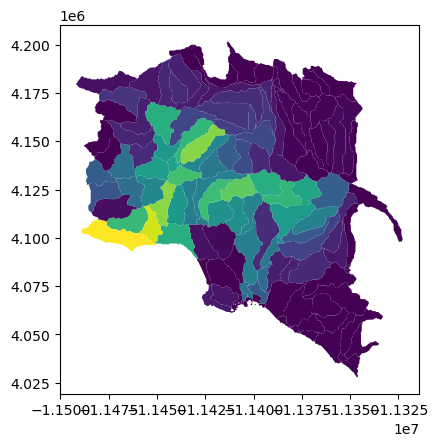

In [28]:
b.plot(column="fburnt")
plt.savefig("fburnt.png")

This map shows which basins are most vulnerable to fire-exacerbated discharge.

#### Step 3: Map fire-related discharge enchancement to current flood risk.

First, import the flood data (full credit to Hannah for finding and converting it to GeoJSON)

In [29]:
d = gpd.read_file('data/flood_r.geojson').to_crs(epsg=6933)

As above, convert the dataframe to a list using a ***loop***:

In [30]:
floods = []
for i in list(range(0,d.shape[0])):
    floods.append([d.iloc[i]])

Use a ***loop*** to make a new list of "basins" so the entries include the calculations above.

In [31]:
new_basins = []
for i in list(range(0,b.shape[0])):
    new_basins.append([b.iloc[i]])

As above, we need another triplet of functions. There are slightly different: we want to multiply each area of intersection (flood risk zone * enhanced basin) by the fire-exacerbated discharge enhancement for that basin. Also, this time we will just divide by basin area to scale it directly, rather than as a separate step.

In [32]:
def f4(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f5(b,aa):
    return sum([f4(a,b)*a[0]["fburnt"] for a in aa])
def f6(aa,bb):
    return [f5(b,aa)/b[0]["geometry"].area for b in bb]

Apply these functions to the basins and flood risks: 

In [33]:
enhanced=f6(new_basins,floods)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


And assign the resulting values to the flood zone dataframe, plot it to check, and save the graphic for the presentation.

In [34]:
d["enhanced"]=enhanced

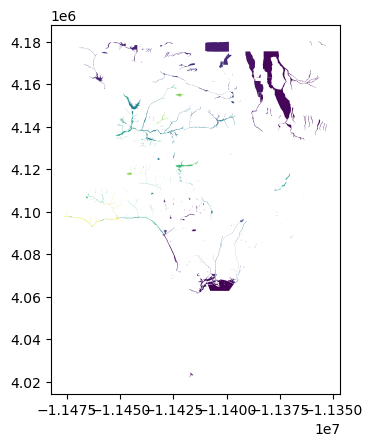

In [35]:
d.plot(column="enhanced")
plt.savefig("flood_enhance.png")

#### Step 4: Allocate enhanced flood risks to census tracts

Use a ***loop*** to make a new list of "floods" so the entries include the calculations above

In [36]:
new_floods = []
for i in list(range(0,d.shape[0])):
    new_floods.append([d.iloc[i]])

Impact census tract data (I'm using CalEnviroScreen as a handy source); as above, use a bounding box to narrow to LA county, and convert to the same coordinate system.

In [37]:
data_file = 'data/calenviroscreen40shpf2021shp.zip'
# Source: https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40
bbox = (100000,-500000,225000,-350000)
c = gpd.read_file(data_file,bbox=bbox).to_crs(epsg=6933)

Filter for just tracts in LA County

In [38]:
c = c[c['County']=="Los Angeles"]

As above, use a ***loop*** to create a list "tracts" with one entry per tract:

In [39]:
tracts = []
for i in list(range(0,c.shape[0])):
    tracts.append([c.iloc[i]])

Here comes the third set of triplet functions. This is very similar to the last, just pulling the "enhanced" value from the flood risk instead of burnt fraction from the basins.

In [40]:
def f7(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f8(b,aa):
    return sum([f7(a,b)*a[0]["enhanced"] for a in aa])
def f9(aa,bb):
    return [f8(b,aa) for b in bb]

Apply this to the intersection of flood zones and census tracts:

In [41]:
impact=f9(new_floods,tracts)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


As before, assign the outputs back to the geodataframe:

In [42]:
c["impact"]=impact

Find the area of each tract and standardize the `impact` values by area

In [43]:
areas = [tract[0]["geometry"].area for tract in tracts]

In [44]:
c["area"]=areas

In [45]:
c["scaled_impact"]=c["impact"]/c["area"]

Plot the data to check and also make the graphic for the presentation

<AxesSubplot: >

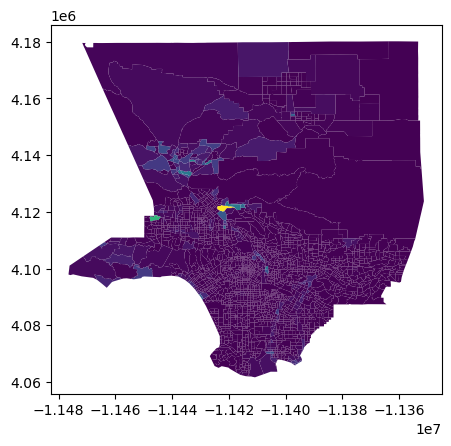

In [46]:
c.plot(column="scaled_impact")

These are the census tracts in LA County with flood risk whose risk is most sensitive to fire-exacerbation, prior to incorporating population vulnerability.

#### Step 5: Integrate with social vulnerability scores

Here we are using CalEnviroScreen (already imported!); ultimate we will use a superior social vulnerability metric

Construct a column of scaled "fire enhanced flood" impact *times* CalEnviroScreen score

In [47]:
c["FEFxCES"]=c["scaled_impact"]*c["CIscoreP"]

Drop tracts without scores and plot

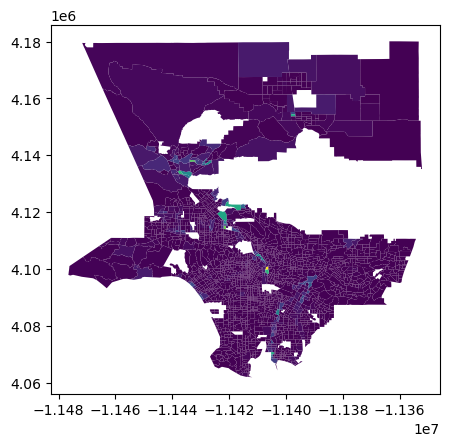

In [48]:
c[c["CIscoreP"]>0].plot(column="FEFxCES")
plt.savefig("fefxces.png")

This map suggests census tracts with flood risk that have high combinations of social vulnerability and fraction of upstream land has historically burned. Flood risk in these tracts perhaps should be re-evaluated in light of the potential for upstream burning to enhance water discharge and flood protection and resilience measures may be particularly valuable in these areas.